<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/Embedding_As_Feature/distilBERT%26distilGPT_Embedding_As_Feature_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00


## Loading Transformers

In [5]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel, AutoConfig
import datasets


gptModel = 'raygx/distilGPT-NepSA'
gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')

gptConfig = AutoConfig.from_pretrained(
          gptModel,
          bos_token_id=gptTokenizer.cls_token_id,
          eos_token_id=gptTokenizer.sep_token_id,
          pad_token_id=gptTokenizer.pad_token_id,
          id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
          label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
        )
gptModel = TFAutoModel.from_pretrained(gptModel,config = gptConfig)

bertModel = 'raygx/distilBERT-NepSA'
bertTokenizer = PreTrainedTokenizerFast.from_pretrained(bertModel)

bertConfig = AutoConfig.from_pretrained(
          bertModel,
          cls_token_id=bertTokenizer.cls_token_id,
          sep_token_id=bertTokenizer.sep_token_id,
          pad_token_id=bertTokenizer.pad_token_id,
          id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
          label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
        )
bertModel = TFAutoModel.from_pretrained(bertModel,config = bertConfig)

gptModel.config, bertModel.config

Some layers from the model checkpoint at raygx/distilGPT-NepSA were not used when initializing TFGPT2Model: ['score']
- This IS expected if you are initializing TFGPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFGPT2Model were initialized from the model checkpoint at raygx/distilGPT-NepSA.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.
Some layers from the model checkpoint at raygx/distilBERT-NepSA were not used when initializing TFDistilBertModel: ['dropout_39', 'classifier', 'pre_classifier']
- This IS 

(GPT2Config {
   "_name_or_path": "raygx/distilGPT-NepSA",
   "_num_labels": 1,
   "activation_function": "gelu_new",
   "architectures": [
     "GPT2ForSequenceClassification"
   ],
   "attn_pdrop": 0.1,
   "bos_token_id": 1,
   "embd_pdrop": 0.1,
   "eos_token_id": 2,
   "id2label": {
     "0": "NEUTRAL",
     "1": "POSITIVE",
     "2": "NEGATIVE"
   },
   "initializer_range": 0.02,
   "label2id": {
     "NEGATIVE": 2,
     "NEUTRAL": 0,
     "POSITIVE": 1
   },
   "layer_norm_epsilon": 1e-05,
   "model_type": "gpt2",
   "n_ctx": 1024,
   "n_embd": 768,
   "n_head": 12,
   "n_inner": null,
   "n_layer": 6,
   "n_positions": 1024,
   "pad_token_id": 3,
   "reorder_and_upcast_attn": false,
   "resid_pdrop": 0.1,
   "scale_attn_by_inverse_layer_idx": false,
   "scale_attn_weights": true,
   "summary_activation": null,
   "summary_first_dropout": 0.1,
   "summary_proj_to_labels": true,
   "summary_type": "cls_index",
   "summary_use_proj": true,
   "task_specific_params": {
     "text-ge

## Loading Data

In [9]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/41541 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [10]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [11]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

Map (num_proc=4):   0%|          | 0/33232 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8309 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

## Creating Embedding Layer

In [16]:
import tensorflow as tf

class distilGPTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',trailing_context=4,truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.tokenizer.padding_side = 'left'
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trailing_context = trailing_context
    self.trainable=False

  def call(self, x):
    embeddings = self.embedding(
                  self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
                )[0][:,-self.trailing_context:,:]

    return tf.reduce_logsumexp(embeddings,axis=1)

class distilBERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    x = self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))
    return x['last_hidden_state'][:,0,:]

In [19]:
# model.bert(tokenizer('बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको',padding='max_length',truncation=True,return_tensors='tf',max_length=128))
gpt_embd = distilGPTEmbedding(gptModel,gptTokenizer,max_token_len=100,trailing_context=2)
bert_embd = distilBERTEmbedding(bertModel,bertTokenizer,max_token_len=100)
# embd(["",'बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको','बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको'])
print(tf.concat([gpt_embd(["abcd",'efgh']),bert_embd(["abcd",'efgh'])],axis=1))
d_model = tf.concat([gpt_embd(["abcd",'efgh']),bert_embd(["abcd",'efgh'])],axis=1).shape[1]
d_model

tf.Tensor(
[[ 1.7374524   1.8753467   2.0207448  ... -0.40321526 -1.0253834
   0.39130825]
 [ 3.5997598   2.13968    -2.192185   ... -0.3517984  -1.0502453
   0.658915  ]], shape=(2, 1536), dtype=float32)


1536

## Creating Data Generator

In [20]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data,model_dim, batch_size=32,shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data
        self.embeddings = np.empty((data.num_rows,model_dim))
        self.shuffle = shuffle
        # self.average = tf.keras.layers.Average()
        self.is_first_epoch = True
        self.on_epoch_end(is_first_epoch=self.is_first_epoch)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.data.num_rows / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)

    def on_epoch_end(self,is_first_epoch=False):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.data.num_rows)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        self.is_first_epoch = is_first_epoch


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        chunk = self.data.select(indexes)

        if self.is_first_epoch:
          X = tf.concat([gpt_embd(chunk['text']), bert_embd(chunk['text'])],axis=1)
          self.embeddings[indexes] = X
        else:
          X = self.embeddings[indexes]

        y = np.array(chunk['label'])
        return X,y

In [21]:
%%time

train_features = DataGenerator(data['train'],model_dim=d_model,batch_size=32)
test_features = DataGenerator(data['test'],model_dim=d_model,shuffle=False)

CPU times: user 1.45 ms, sys: 0 ns, total: 1.45 ms
Wall time: 1.29 ms


## Classification Head

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(d_model)),
    tf.keras.layers.Dense(768,activation='gelu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(3,activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-4,
        weight_decay=0.4
      ),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 768)               1180416   
                                                                 
 dropout_153 (Dropout)       (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 2307      
                                                                 
Total params: 1,182,723
Trainable params: 1,182,723
Non-trainable params: 0
_________________________________________________________________


## Training Classification

In [29]:
history = model.fit(train_features,
        epochs=100,
        validation_data=test_features,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_acc', patience=3,
                            verbose=1, mode='auto',
                            restore_best_weights=True)
                        ])

Epoch 1/100
1039/1039 [==============================] - 12s 9ms/step - loss: 0.4070 - acc: 0.8473 - val_loss: 0.3840 - val_acc: 0.8511
Epoch 2/100
1039/1039 [==============================] - 7s 7ms/step - loss: 0.3736 - acc: 0.8558 - val_loss: 0.3852 - val_acc: 0.8518
Epoch 3/100
1039/1039 [==============================] - 8s 8ms/step - loss: 0.3708 - acc: 0.8558 - val_loss: 0.3818 - val_acc: 0.8502
Epoch 4/100
1039/1039 [==============================] - 7s 7ms/step - loss: 0.3693 - acc: 0.8569 - val_loss: 0.3642 - val_acc: 0.8595
Epoch 5/100
1039/1039 [==============================] - 8s 8ms/step - loss: 0.3671 - acc: 0.8568 - val_loss: 0.3736 - val_acc: 0.8589
Epoch 6/100
1039/1039 [==============================] - 7s 7ms/step - loss: 0.3678 - acc: 0.8577 - val_loss: 0.3696 - val_acc: 0.8546
Epoch 7/100
1039/1039 [==============================] - 8s 8ms/step - loss: 0.3665 - acc: 0.8575 - val_loss: 0.3722 - val_acc: 0.8573
Epoch 7: early stopping


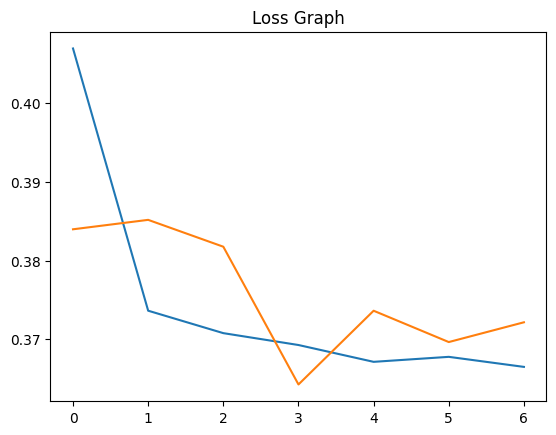

Text(0.5, 1.0, 'Accuracy Graph')

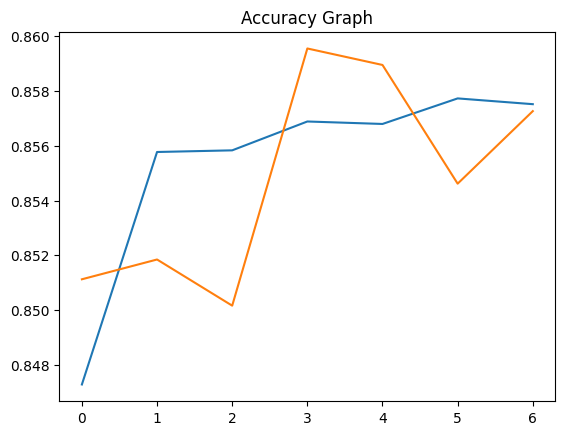

In [30]:
import seaborn
from matplotlib import pyplot as plt

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])
plt.title("Loss Graph")
plt.show()

seaborn.lineplot(history.history['acc'])
seaborn.lineplot(history.history['val_acc'])
plt.title("Accuracy Graph")

## Model Evaluation

In [31]:
%%time
print("Getting Test Prediction")
pred_labels = [np.argmax(x) for x in model.predict(test_features)]

actual_labels = data['test']['label']

Getting Test Prediction
260/260 [==============================] - 1s 4ms/step
CPU times: user 1.2 s, sys: 77.2 ms, total: 1.28 s
Wall time: 1.13 s


In [32]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.8595972418351812
Precision-Score 0.8604113357911536
Recall-Score 0.8595498856661451
accuracy_Score 0.8595498856661451


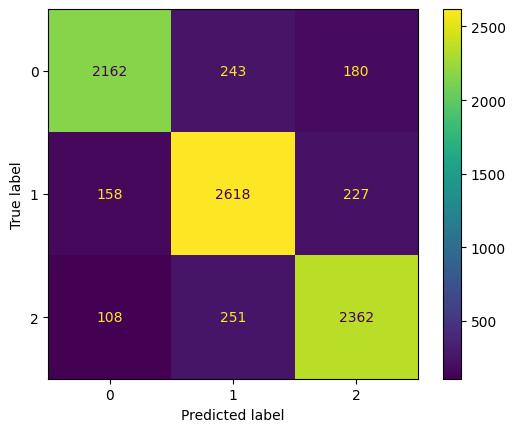

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()